## Version Check

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.python.layers.normalization import BatchNormalization
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

2023-01-27 18:33:38.567491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 18:33:38.693250: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-27 18:33:38.732354: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-27 18:33:39.395100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1.4.4
1.22.4
3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]
1.1.2


# Step 0 - Data Loading

## 0.1- Load Dataset

In [2]:
train = pd.read_csv("KDDTrain+.csv")
test = pd.read_csv("KDDTest+.csv")
train.drop('num_learners', inplace=True, axis=1)
test.drop('num_learners', inplace=True, axis=1)
# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',train.shape)
print('Dimensions of the Test set:',test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22543, 42)


## 0.2- Simple View Dataset

In [3]:
train.head(5)
# df_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## 0.3- Distribution of Training dataset and Testing dataset

In [4]:
print('Label distribution Training set:')
print(train['attack_class'].value_counts())
print()
print('Label distribution Test set:')
print(test['attack_class'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack_class, dtype: int64

Label distribution Test set:
normal             9710
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack    

# Step 1 - Data Pre processing

## 1.1- Identify categorical features

In [5]:
#colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in train.columns:
    if train[col_name].dtypes == 'object' :
        unique_cat = len(train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in protocol_type:')
print(train['protocol_type'].value_counts().sort_values(ascending=False))
print('Distribution of some categories in service:')
print(train['service'].value_counts().sort_values(ascending=False).head())
print('Distribution of categories in flag:')
print(train['flag'].value_counts().sort_values(ascending=False).head())
print('Distribution of categories in attack_class:')
print(train['attack_class'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'attack_class' has 23 categories

Distribution of categories in protocol_type:
tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64
Distribution of some categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64
Distribution of categories in flag:
SF      74945
S0      34851
REJ     11233
RSTR     2421
RSTO     1562
Name: flag, dtype: int64
Distribution of categories in attack_class:
normal       67343
neptune      41214
satan         3633
ipsweep       3599
portsweep     2931
Name: attack_class, dtype: int64


##### Now we examine above information for test dataset

In [6]:
# Test set
print('Test set:')
for col_name in test.columns:
    if test[col_name].dtypes == 'object' :
        unique_cat = len(test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 63 categories
Feature 'flag' has 11 categories
Feature 'attack_class' has 38 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
#### Comparing the results shows that the Test set has fewer categories (7), these need to be added as empty columns.

## 1.1- Group attacks and map them to integer:

In [7]:
train_label = train['attack_class'].copy(deep=True)
test_label = test['attack_class'].copy(deep=True)
train_label.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4}, inplace=True)
test_label.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4}, inplace=True)

train['attack_class'] = train_label
test['attack_class'] = test_label
train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


## 1.2- Convert categorical columns to numerical columns:

### Insert categorical features into a 2D numpy array

In [8]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
 # Get the categorical values into a 2D numpy array
df_categorical_values = train[categorical_columns]
testdf_categorical_values = test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


### Make column names for dummies

In [9]:
# protocol type
unique_protocol=sorted(train.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(train.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(train.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

### Transform categorical features into numbers using LabelEncoder()

In [10]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)


   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


### One-Hot Encoding

In [11]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
# print('Salam')
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()


,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add 6 missing categories from train set to test set

In [12]:
trainservice = train['service'].tolist()
testservice = test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_tftp_u',
 'service_harvest',
 'service_http_2784',
 'service_http_8001',
 'service_urh_i',
 'service_aol',
 'service_red_i']

In [13]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape


(22543, 84)

### Join encoded categorical dataframe with the non-categorical dataframe

In [14]:
newdf=train.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)



(125973, 123)
(22543, 123)


## 1.3- Normalizing and create dataset for training:

In [15]:
from sklearn import preprocessing
x_train = newdf.copy(deep=True)
x_test = newdf_test.copy(deep=True)
x_train = newdf.drop(['attack_class'], axis=1).copy(deep = True)
x = x_train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_train = pd.DataFrame(x_scaled)

x_test = newdf_test.drop(['attack_class'], axis=1).copy(deep = True)
x = x_test.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_test = pd.DataFrame(x_scaled)

x_train.columns = newdf.columns.difference(['attack_class'])
x_test.columns = newdf_test.columns.difference(['attack_class'])
x_train['attack_class'] = newdf['attack_class']
x_test['attack_class'] = newdf_test['attack_class']
x_train

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,...,service_whois,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment,attack_class
0,0.000000,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.000000,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.000000,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,0.000186,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0.000000,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


## 1.4- Separate features and attacks type for all 4 kinds of attacks:

In [16]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=x_train[~x_train['attack_class'].isin(to_drop_DoS)]
Probe_df=x_train[~x_train['attack_class'].isin(to_drop_Probe)]
R2L_df=x_train[~x_train['attack_class'].isin(to_drop_R2L)]
U2R_df=x_train[~x_train['attack_class'].isin(to_drop_U2R)]
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)

DoS_df_test=x_test[~x_test['attack_class'].isin(to_drop_DoS)]
Probe_df_test=x_test[~x_test['attack_class'].isin(to_drop_Probe)]
R2L_df_test=x_test[~x_test['attack_class'].isin(to_drop_R2L)]
U2R_df_test=x_test[~x_test['attack_class'].isin(to_drop_U2R)]
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17170, 123)
Dimensions of Probe: (12131, 123)
Dimensions of R2L: (12595, 123)
Dimensions of U2R: (9777, 123)


In [17]:
X_DoS = DoS_df.drop('attack_class',1)
Y_DoS = DoS_df.attack_class
X_Probe = Probe_df.drop('attack_class',1)
Y_Probe = Probe_df.attack_class
X_R2L = R2L_df.drop('attack_class',1)
Y_R2L = R2L_df.attack_class
X_U2R = U2R_df.drop('attack_class',1)
Y_U2R = U2R_df.attack_class

X_DoS_test = DoS_df_test.drop('attack_class',1)
Y_DoS_test = DoS_df_test.attack_class
X_Probe_test = Probe_df_test.drop('attack_class',1)
Y_Probe_test = Probe_df_test.attack_class
X_R2L_test = R2L_df_test.drop('attack_class',1)
Y_R2L_test = R2L_df_test.attack_class
X_U2R_test = U2R_df_test.drop('attack_class',1)
Y_U2R_test = U2R_df_test.attack_class

train.drop('attack_class', axis=1, inplace=True)
test.drop('attack_class', axis=1, inplace=True)

/tmp/ipykernel_190/2683199128.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS = DoS_df.drop('attack_class',1)
/tmp/ipykernel_190/2683199128.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_Probe = Probe_df.drop('attack_class',1)
/tmp/ipykernel_190/2683199128.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_R2L = R2L_df.drop('attack_class',1)
/tmp/ipykernel_190/2683199128.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_U2R = U2R_df.drop('attack_class',1)
/tmp/ipykernel_190/2683199128.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-o

In [18]:
X_DoS.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,...,service_vmnet,service_whois,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
Y_DoS.head()

0    0
1    0
2    1
3    0
4    0
Name: attack_class, dtype: int64

## 3.1 Linear Models

In [20]:
all_DoS_accuracy = [None] * 15
all_DoS_precision = [None] * 15
all_DoS_recall = [None] * 15

all_Probe_accuracy = [None] * 15
all_Probe_precision = [None] * 15
all_Probe_recall = [None] * 15

all_U2R_accuracy = [None] * 15
all_U2R_precision = [None] * 15
all_U2R_recall = [None] * 15

all_R2L_accuracy = [None] * 15
all_R2L_precision = [None] * 15
all_R2L_recall = [None] * 15


### 3.1.1- Linear Regression:

In [21]:
from sklearn.linear_model import LogisticRegression
def getLRClf():
    clf = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000)
    return clf


#### DoS

In [22]:
DoS_clf = getLRClf()
DoS_clf.fit(X_DoS, Y_DoS)
Y_DoS_pred = DoS_clf.predict(X_DoS_test)
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])



Predicted attacks,0,1
Actual attacks,,
0,9580,130
1,2413,5047


In [23]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
all_DoS_accuracy[0] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
all_DoS_precision[0] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
all_DoS_recall[0] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))



Accuracy: 0.97070 (+/- 0.00689)
Precision: 0.98188 (+/- 0.01117)
Recall: 0.95013 (+/- 0.01130)


#### Probe

In [24]:
Probe_clf = getLRClf()
Probe_clf.fit(X_Probe, Y_Probe)
Y_Probe_pred = Probe_clf.predict(X_Probe_test)
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])



Predicted attacks,0,2
Actual attacks,,
0,9378,332
2,596,1825


In [25]:
accuracy = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
all_Probe_accuracy[0] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
all_Probe_precision[0] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
all_Probe_recall[0] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.98343 (+/- 0.00400)
Precision: 0.96694 (+/- 0.00915)
Recall: 0.98267 (+/- 0.00768)


#### R2L

In [26]:
R2L_clf = getLRClf()
R2L_clf.fit(X_R2L, Y_R2L)
Y_R2L_pred = R2L_clf.predict(X_R2L_test)
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,3
Actual attacks,,
0,9661,49
3,2489,396


In [27]:
accuracy = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
all_R2L_accuracy[0] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
all_R2L_precision[0] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
all_R2L_recall[0] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.95975 (+/- 0.01192)
Precision: 0.93426 (+/- 0.01926)
Recall: 0.95611 (+/- 0.01404)


#### U2R

In [28]:
U2R_clf = getLRClf()
U2R_clf.fit(X_U2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_U2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0
Actual attacks,
0,9710
4,67


In [29]:
accuracy = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
all_U2R_accuracy[0] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
all_U2R_precision[0] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
all_U2R_recall[0] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.99315 (+/- 0.00159)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning

Precision: 0.62173 (+/- 0.40337)
Recall: 0.52127 (+/- 0.06544)


## Graphical Comparison (LR)

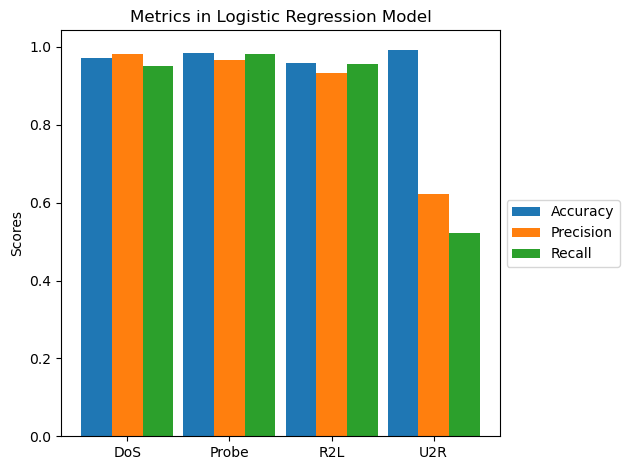

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['DoS', 'Probe', 'R2L', 'U2R']
accuracy_values = [all_DoS_accuracy[0], all_Probe_accuracy[0], all_R2L_accuracy[0], all_U2R_accuracy[0]]
precision_values = [all_DoS_precision[0], all_Probe_precision[0], all_R2L_precision[0], all_U2R_precision[0]]
recall_values = [all_DoS_recall[0], all_Probe_recall[0], all_R2L_recall[0], all_U2R_recall[0]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x, precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in Logistic Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 3, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
#
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

plt.show()


## 3.2 Support Vector Machines:

### 3.2.1- SVC

In [31]:
from sklearn.svm import LinearSVC
def getSVCClf():
    return LinearSVC()


#### DoS

In [32]:
DoS_clf = getSVCClf()
DoS_clf.fit(X_DoS, Y_DoS)
Y_DoS_pred = DoS_clf.predict(X_DoS_test)
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,1
Actual attacks,,
0,9606,104
1,2056,5404


In [33]:
accuracy = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
all_DoS_accuracy[1] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
all_DoS_precision[1] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
all_DoS_recall[1] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.97554 (+/- 0.00634)
Precision: 0.98635 (+/- 0.00863)
Recall: 0.95697 (+/- 0.01359)


#### Probe

In [34]:
Probe_clf = getSVCClf()
Probe_clf.fit(X_Probe, Y_Probe)
Y_Probe_pred = Probe_clf.predict(X_Probe_test)
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,2
Actual attacks,,
0,8985,725
2,468,1953


In [35]:
accuracy = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
all_Probe_accuracy[1] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
all_Probe_precision[1] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
all_Probe_recall[1] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))



Accuracy: 0.98343 (+/- 0.00492)
Precision: 0.96954 (+/- 0.00935)
Recall: 0.97941 (+/- 0.01019)


#### U2R

In [36]:
U2R_clf = getSVCClf()
U2R_clf.fit(X_U2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_U2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])
# print(accuracy_score(Y_U2R_test, Y_U2R_pred))


Predicted attacks,0,4
Actual attacks,,
0,9696,14
4,49,18


In [37]:
accuracy = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
all_U2R_accuracy[1] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
all_U2R_precision[1] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
all_U2R_recall[1] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))



Accuracy: 0.99642 (+/- 0.00333)
Precision: 0.91803 (+/- 0.16324)
Recall: 0.81967 (+/- 0.16143)


#### R2L

In [38]:
R2L_clf = getSVCClf()
R2L_clf.fit(X_R2L, Y_R2L)
Y_R2L_pred = R2L_clf.predict(X_R2L_test)
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,3
Actual attacks,,
0,9694,16
3,2866,19


In [39]:
accuracy = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
all_R2L_accuracy[1] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
all_R2L_precision[1] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
all_R2L_recall[1] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.96546 (+/- 0.00948)
Precision: 0.94389 (+/- 0.01550)
Recall: 0.96116 (+/- 0.01332)


## Graphical Comparison (LR)

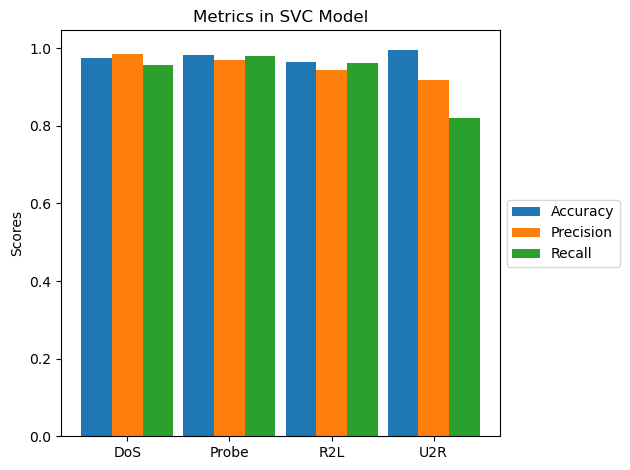

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['DoS', 'Probe', 'R2L', 'U2R']
accuracy_values = [all_DoS_accuracy[1], all_Probe_accuracy[1], all_R2L_accuracy[1], all_U2R_accuracy[1]]
precision_values = [all_DoS_precision[1], all_Probe_precision[1], all_R2L_precision[1], all_U2R_precision[1]]
recall_values = [all_DoS_recall[1], all_Probe_recall[1], all_R2L_recall[1], all_U2R_recall[1]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in SVC Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 3, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
#
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

plt.show()


## 3.3- Deep Models:

### 3.3.1- DNN

#### DoS

In [41]:
from sklearn.neural_network import MLPClassifier
DoS_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
DoS_clf.fit(X_DoS, Y_DoS)
Y_DoS_pred = DoS_clf.predict(X_DoS_test)
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,1
Actual attacks,,
0,9577,133
1,1890,5570


In [42]:
accuracy = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='accuracy')
all_DoS_accuracy[2] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='precision')
all_DoS_precision[2] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(DoS_clf, X_DoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='recall')
all_DoS_recall[2] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.99511 (+/- 0.00023)
Precision: 0.99358 (+/- 0.00265)
Recall: 0.99517 (+/- 0.00214)


#### Probe

In [43]:
Probe_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
Probe_clf.fit(X_Probe, Y_Probe)
Y_Probe_pred = Probe_clf.predict(X_Probe_test)
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,2
Actual attacks,,
0,9400,310
2,1121,1300


In [44]:
accuracy = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, n_jobs=3, cv=2, scoring='accuracy')
all_Probe_accuracy[2] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, n_jobs=3, cv=2, scoring='precision_macro')
all_Probe_precision[2] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(Probe_clf, X_Probe_test, Y_Probe_test, n_jobs=3, cv=2, scoring='recall_macro')
all_Probe_recall[2] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


#


Accuracy: 0.99036 (+/- 0.00017)
Precision: 0.98557 (+/- 0.00071)
Recall: 0.98421 (+/- 0.00020)


#### U2R

In [45]:
U2R_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
U2R_clf.fit(X_U2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_U2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])



Predicted attacks,0,4
Actual attacks,,
0,9704,6
4,60,7


In [46]:
accuracy = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='accuracy')
all_U2R_accuracy[2] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='precision_macro')
all_U2R_precision[2] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_U2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='recall_macro')
all_U2R_recall[2] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
#


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.99703 (+/- 0.00143)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision: 0.91390 (+/- 0.06340)
Recall: 0.85800 (+/- 0.04096)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### R2L

In [47]:
R2L_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
R2L_clf.fit(X_R2L, Y_R2L)
Y_R2L_pred = R2L_clf.predict(X_R2L_test)
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])



Predicted attacks,0,3
Actual attacks,,
0,9667,43
3,2857,28


In [48]:
accuracy = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, n_jobs=3, cv=2, scoring='accuracy')
all_R2L_accuracy[2] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, n_jobs=3, cv=2, scoring='precision_macro')
all_R2L_precision[2] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(R2L_clf, X_R2L_test, Y_R2L_test, n_jobs=3, cv=2, scoring='recall_macro')
all_R2L_recall[2] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.96943 (+/- 0.00080)
Precision: 0.94919 (+/- 0.00386)
Recall: 0.96678 (+/- 0.00288)


### Graphical Comparison

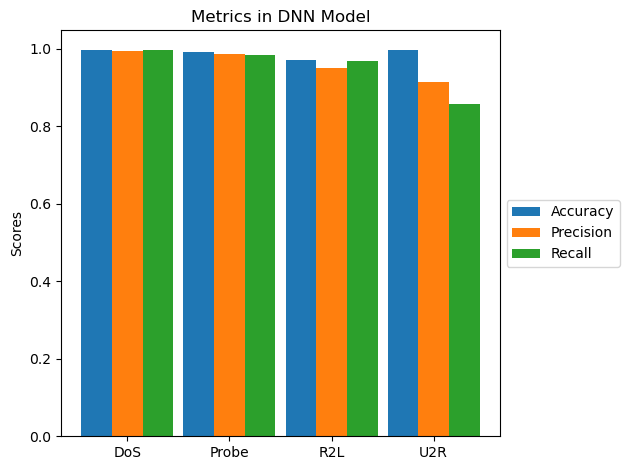

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['DoS', 'Probe', 'R2L', 'U2R']
accuracy_values = [all_DoS_accuracy[2], all_Probe_accuracy[2], all_R2L_accuracy[2], all_U2R_accuracy[2]]
precision_values = [all_DoS_precision[2], all_Probe_precision[2], all_R2L_precision[2], all_U2R_precision[2]]
recall_values = [all_DoS_recall[2], all_Probe_recall[2], all_R2L_recall[2], all_U2R_recall[2]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in DNN Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 3, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
#
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

plt.show()


## Graphical comparison between models per attacks

### DoS:

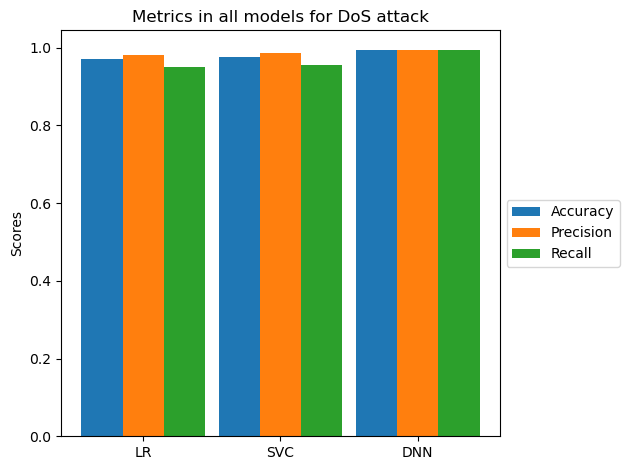

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['LR', 'SVC', 'DNN']
accuracy_values = [all_DoS_accuracy[0], all_DoS_accuracy[1], all_DoS_accuracy[2]]
precision_values = [all_DoS_precision[0], all_DoS_precision[1], all_DoS_precision[2]]
recall_values = [all_DoS_recall[0], all_DoS_recall[1], all_DoS_recall[2]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in all models for DoS attack')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()


### Probe

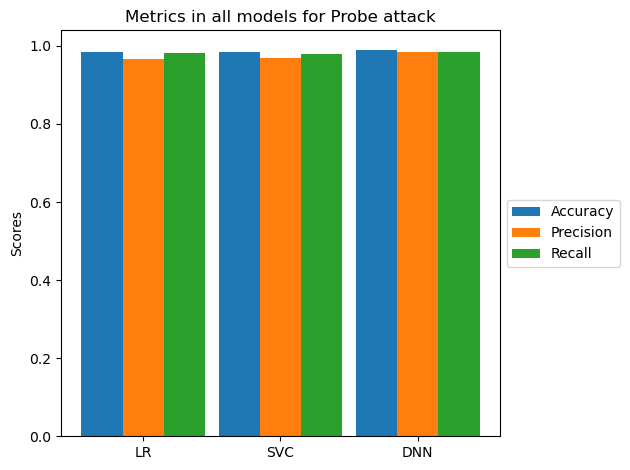

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['LR', 'SVC', 'DNN']
accuracy_values = [all_Probe_accuracy[0], all_Probe_accuracy[1], all_Probe_accuracy[2]]
precision_values = [all_Probe_precision[0], all_Probe_precision[1], all_Probe_precision[2]]
recall_values = [all_Probe_recall[0], all_Probe_recall[1], all_Probe_recall[2]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in all models for Probe attack')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()


### U2R:

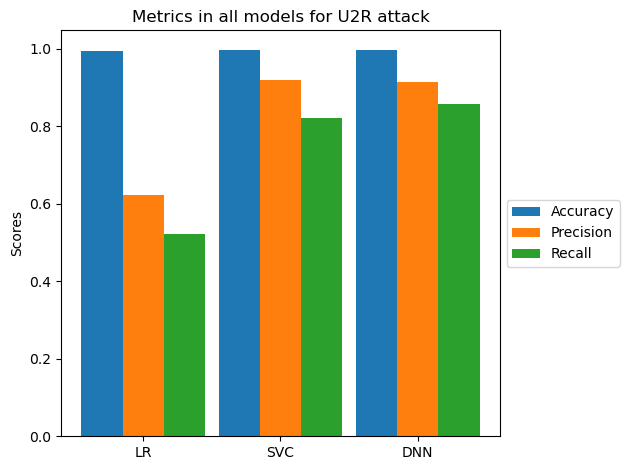

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['LR', 'SVC', 'DNN']
accuracy_values = [all_U2R_accuracy[0], all_U2R_accuracy[1], all_U2R_accuracy[2]]
precision_values = [all_U2R_precision[0], all_U2R_precision[1], all_U2R_precision[2]]
recall_values = [all_U2R_recall[0], all_U2R_recall[1], all_U2R_recall[2]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in all models for U2R attack')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()


### R2L Attacks:


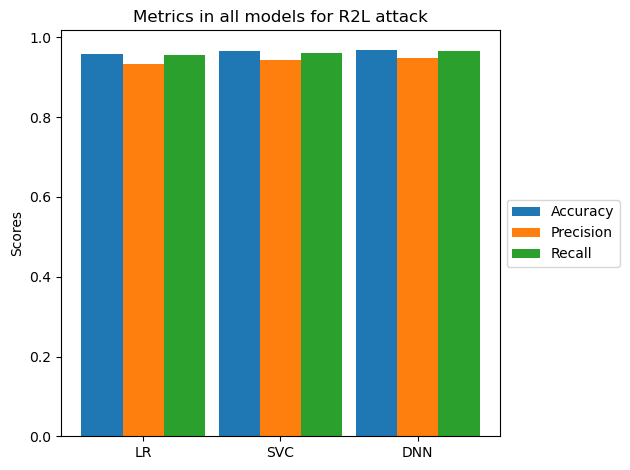

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['LR', 'SVC', 'DNN']
accuracy_values = [all_R2L_accuracy[0], all_R2L_accuracy[1], all_R2L_accuracy[2]]
precision_values = [all_R2L_precision[0], all_R2L_precision[1], all_R2L_precision[2]]
recall_values = [all_R2L_recall[0], all_R2L_recall[1], all_R2L_recall[2]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in all models for R2L attack')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()

## Feature Selection

###

In [54]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore')
selector=SelectPercentile(f_classif, percentile=20)

X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS_test = selector.fit_transform(X_DoS_test,Y_DoS_test)
# X_newDoS.shape
X_newDoS_test.shape


X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe_test = selector.fit_transform(X_Probe_test, Y_Probe_test)
X_newProbe.shape

X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R_test = selector.fit_transform(X_U2R_test, Y_U2R_test)
X_newU2R.shape

X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L_test = selector.fit_transform(X_R2L_test, Y_R2L_test)
X_newR2L.shape


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [  5  14  16  17  82 104 114 115 116 117 118 119 120 121] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [  3   5  14  16  17  43  47  48  50  56  57  62  67  68  69  72  75  76
  85  88  92  94 101 102 103 115 116 117 118 119 120 121] are constant.

(68338, 25)

# DNN

### DoS

In [58]:
from sklearn.neural_network import MLPClassifier

all_DoS_f_score = [None] * 15
DoS_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
DoS_clf.fit(X_newDoS, Y_DoS)
Y_DoS_pred = DoS_clf.predict(X_newDoS_test)
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])



Predicted attacks,0,1
Actual attacks,,
0,9252,458
1,2421,5039


In [59]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=5, scoring='accuracy')
all_DoS_accuracy[10] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=5, scoring='precision')
all_DoS_precision[10] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=5, scoring='recall')
all_DoS_recall[10] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_DoS_f_score[10] = (1 + b2) * ((all_DoS_precision[10] * all_DoS_recall[10]) / (b2 * all_DoS_precision[10] + all_DoS_recall[10]))
print("F_beta_score: ", all_DoS_f_score[10])


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.99546 (+/- 0.00318)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision: 0.99557 (+/- 0.00504)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Recall: 0.99397 (+/- 0.00339)
F_beta_score:  0.9950449542532013


### Probe

In [60]:
all_Probe_f_score = [None] * 15

Probe_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
Probe_clf.fit(X_newProbe, Y_Probe)
Y_Probe_pred = Probe_clf.predict(X_newProbe_test)
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,2
Actual attacks,,
0,9533,177
2,829,1592


In [61]:
accuracy = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, n_jobs=3, cv=5, scoring='accuracy')
all_Probe_accuracy[10] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, n_jobs=3, cv=5, scoring='precision_macro')
all_Probe_precision[10] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, n_jobs=3, cv=5, scoring='recall_macro')
all_Probe_recall[10] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_Probe_f_score[10] = (1 + b2) * ((all_Probe_precision[10] * all_Probe_recall[10]) / (b2 * all_Probe_precision[10] + all_Probe_recall[10]))
print("F_beta_score: ", all_Probe_f_score[10])


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.98351 (+/- 0.00411)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision: 0.97164 (+/- 0.01115)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Recall: 0.97730 (+/- 0.01029)
F_beta_score:  0.9734938513720486


### U2R

In [62]:
all_U2R_f_score = [None] * 15

U2R_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0
Actual attacks,
0,9710
4,67


In [63]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='accuracy')
all_U2R_accuracy[10] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='precision_macro')
all_U2R_precision[10] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='recall_macro')
all_U2R_recall[10] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_U2R_f_score[10] = (1 + b2) * ((all_U2R_precision[10] * all_U2R_recall[10]) / (b2 * all_U2R_precision[10] + all_U2R_recall[10]))
print("F_beta_score: ", all_U2R_f_score[10])

Accuracy: 0.99652 (+/- 0.00164)
Precision: 0.90537 (+/- 0.10430)
Recall: 0.82746 (+/- 0.10202)
F_beta_score:  0.8781742575039181


### R2L

In [64]:
all_R2L_f_score = [None] * 15

R2L_clf = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='relu', solver='adam', random_state=1)
R2L_clf.fit(X_newR2L, Y_R2L)
Y_R2L_pred = R2L_clf.predict(X_newR2L_test)
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,3
Actual attacks,,
0,9653,57
3,2511,374


In [65]:
accuracy = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, n_jobs=3, cv=5, scoring='accuracy')
all_R2L_accuracy[10] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, n_jobs=3, cv=5, scoring='precision_macro')
all_R2L_precision[10] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, n_jobs=3, cv=5, scoring='recall_macro')
all_R2L_recall[10] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_R2L_f_score[10] = (1 + b2) * ((all_R2L_precision[10] * all_R2L_recall[10]) / (b2 * all_R2L_precision[10] + all_R2L_recall[10]))
print("F_beta_score: ", all_R2L_f_score[10])


Accuracy: 0.96824 (+/- 0.00372)
Precision: 0.94886 (+/- 0.00903)
Recall: 0.96332 (+/- 0.00563)
F_beta_score:  0.9535662346161886


## Graphical comparison feature selection

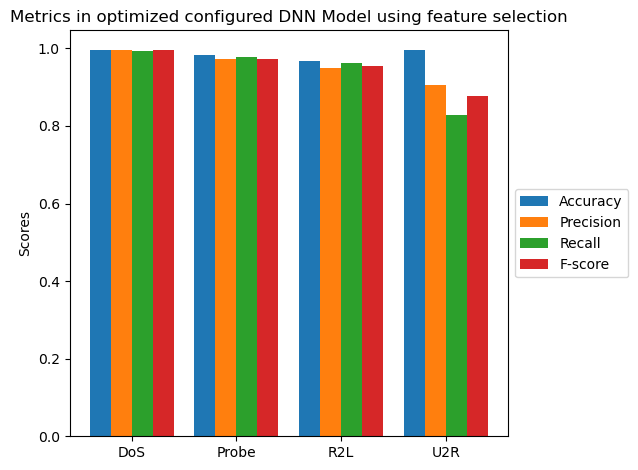

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['DoS', 'Probe', 'R2L', 'U2R']
accuracy_values = [all_DoS_accuracy[10], all_Probe_accuracy[10], all_R2L_accuracy[10], all_U2R_accuracy[10]]
precision_values = [all_DoS_precision[10], all_Probe_precision[10], all_R2L_precision[10], all_U2R_precision[10]]
recall_values = [all_DoS_recall[10], all_Probe_recall[10], all_R2L_recall[10], all_U2R_recall[10]]
f_score_value = [all_DoS_f_score[10], all_Probe_f_score[10], all_R2L_f_score[10], all_U2R_f_score[10]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x - width/2 , precision_values, width, label='Precision')
rects3 = ax.bar(x + width/2 , recall_values, width, label='Recall')
rects3 = ax.bar(x + 3*width/2, f_score_value, width, label='F-score')

ax.set_ylabel('Scores')
ax.set_title('Metrics in optimized configured DNN Model using feature selection')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()


### SVC

### DoS

In [67]:
from sklearn.svm import LinearSVC
def getSVCClf():
    return LinearSVC()


In [68]:
DoS_clf = getSVCClf()
DoS_clf.fit(X_newDoS, Y_DoS)
Y_DoS_pred = DoS_clf.predict(X_newDoS_test)
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,1
Actual attacks,,
0,2493,7217
1,756,6704


In [69]:
accuracy = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='accuracy')
all_DoS_accuracy[4] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='precision')
all_DoS_precision[4] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(DoS_clf, X_newDoS_test, Y_DoS_test, n_jobs=3, cv=2, scoring='recall')
all_DoS_recall[4] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.97012 (+/- 0.00268)
Precision: 0.97983 (+/- 0.00384)
Recall: 0.95080 (+/- 0.00241)


### Probe

In [70]:
Probe_clf = getSVCClf()
Probe_clf.fit(X_newProbe, Y_Probe)
Y_Probe_pred = Probe_clf.predict(X_newProbe_test)
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,2
Actual attacks,,
0,9536,174
2,1029,1392


In [71]:
accuracy = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, cv=10, scoring='accuracy')
all_Probe_accuracy[4] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, cv=10, scoring='precision_macro')
all_Probe_precision[4] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(Probe_clf, X_newProbe_test, Y_Probe_test, cv=10, scoring='recall_macro')
all_Probe_recall[4] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.96843 (+/- 0.00734)
Precision: 0.94909 (+/- 0.01238)
Recall: 0.95268 (+/- 0.01778)


### U2R

In [72]:
U2R_clf = getSVCClf()
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0
Actual attacks,
0,9710
4,67


In [73]:
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, cv=10, scoring='accuracy')
all_U2R_accuracy[4] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
all_U2R_precision[4] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
all_U2R_recall[4] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.99570 (+/- 0.00153)
Precision: 0.92982 (+/- 0.14159)
Recall: 0.72945 (+/- 0.08636)


### R2L

In [74]:
R2L_clf = getSVCClf()
R2L_clf.fit(X_newR2L, Y_R2L)
Y_R2L_pred = R2L_clf.predict(X_newR2L_test)
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])


Predicted attacks,0,3
Actual attacks,,
0,9143,567
3,2746,139


In [75]:
accuracy = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, cv=10, scoring='accuracy')
all_R2L_accuracy[4] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
all_R2L_precision[4] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(R2L_clf, X_newR2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
all_R2L_recall[4] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))


Accuracy: 0.96205 (+/- 0.00869)
Precision: 0.93852 (+/- 0.01503)
Recall: 0.95748 (+/- 0.01166)


## Graphical Comparison

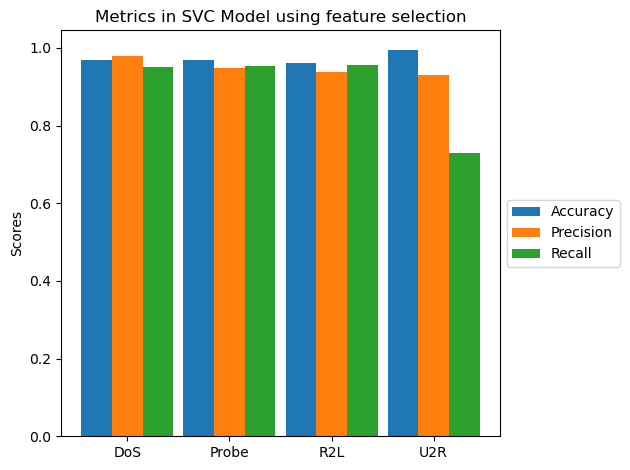

In [76]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['DoS', 'Probe', 'R2L', 'U2R']
accuracy_values = [all_DoS_accuracy[4], all_Probe_accuracy[4], all_R2L_accuracy[4], all_U2R_accuracy[4]]
precision_values = [all_DoS_precision[4], all_Probe_precision[4], all_R2L_precision[4], all_U2R_precision[4]]
recall_values = [all_DoS_recall[4], all_Probe_recall[4], all_R2L_recall[4], all_U2R_recall[4]]
# DoS_values = [all_DoS_accuracy[0], all_DoS_precision[0], all_DoS_recall[0]]
# Probe_values = [all_Probe_accuracy[0], all_Probe_precision[0], all_Probe_recall[0]]
# R2L_values = [all_R2L_accuracy[0], all_R2L_precision[0], all_R2L_recall[0]]
# U2R_values = [all_U2R_accuracy[0], all_U2R_precision[0], all_U2R_recall[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x , precision_values, width, label='Precision')
rects3 = ax.bar(x + width, recall_values, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Metrics in SVC Model using feature selection')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

plt.show()

## Optimize DNN for U2R attack

In [82]:
all_R2L_f_score = [None] * 15

### U2R

#### model 1

In [150]:
from sklearn.neural_network import MLPClassifier
U2R_clf = MLPClassifier(hidden_layer_sizes=(40, 60, 20), activation='relu', solver='adam', random_state=1)
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9710
4,67


In [148]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='accuracy')
all_U2R_accuracy[5] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='precision_macro')
all_U2R_precision[5] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='recall_macro')
all_U2R_recall[5] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_R2L_f_score[5] = (1 + b2) * ((all_U2R_precision[5] * all_U2R_recall[5]) / (b2 * all_U2R_precision[5] + all_U2R_recall[5]))
print("F_beta_score: ", all_R2L_f_score[5])

Accuracy: 0.99734 (+/- 0.00100)
Precision: 0.93498 (+/- 0.09361)
Recall: 0.87371 (+/- 0.13614)
F_beta_score:  0.9139077623061193


#### model 2

In [143]:
U2R_clf = MLPClassifier(hidden_layer_sizes=(64, 128, 32), activation='relu', solver='adam', learning_rate='adaptive'
                        ,random_state=1)
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0
Actual attacks,
0,9710
4,67


In [144]:
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='accuracy')
all_U2R_accuracy[6] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='precision_macro')
all_U2R_precision[6] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='recall_macro')
all_U2R_recall[6] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_R2L_f_score[6] = (1 + b2) * ((all_U2R_precision[6] * all_U2R_recall[6]) / (b2 * all_U2R_precision[6] + all_U2R_recall[6]))
print("F_beta_score: ", all_R2L_f_score[6])

Accuracy: 0.99703 (+/- 0.00077)
Precision: 0.92993 (+/- 0.11021)
Recall: 0.85828 (+/- 0.12750)
F_beta_score:  0.9050825657928805


#### model 3

In [134]:
U2R_clf = MLPClassifier(hidden_layer_sizes=(32, 64, 64, 32), activation='relu', solver='lbfgs', random_state=1)
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

/Users/tahabagheri/.virtualenvs/bachelor_project_venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Predicted attacks,0,4
Actual attacks,,
0,3027,6683
4,60,7


In [135]:
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='accuracy')
all_U2R_accuracy[7] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='precision_macro')
all_U2R_precision[7] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 3))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=5, scoring='recall_macro')
all_U2R_recall[7] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_R2L_f_score[7] = (1 + b2) * ((all_U2R_precision[7] * all_U2R_recall[7]) / (b2 * all_U2R_precision[7] + all_U2R_recall[7]))
print("F_beta_score: ", all_R2L_f_score[7])

Accuracy: 0.99673 (+/- 0.00190)
Precision: 0.90364 (+/- 0.17765)
Recall: 0.86576 (+/- 0.06844)
F_beta_score:  0.890820077078847


#### model 4

In [92]:
U2R_clf = MLPClassifier(hidden_layer_sizes=(64, 128, 32), activation='tanh', solver='adam', random_state=1)
U2R_clf.fit(X_newU2R, Y_U2R)
Y_U2R_pred = U2R_clf.predict(X_newU2R_test)
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9707,3
4,63,4


In [ ]:
accuracy = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='accuracy')
all_U2R_accuracy[8] = accuracy.mean()
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='precision_macro')
all_U2R_precision[8] = precision.mean()
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(U2R_clf, X_newU2R_test, Y_U2R_test, n_jobs=3, cv=2, scoring='recall_macro')
all_U2R_recall[8] = recall.mean()
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
b2 = pow(0.7, 2)
all_R2L_f_score[8] = (1 + b2) * ((all_U2R_precision[8] * all_U2R_recall[8]) / (b2 * all_U2R_precision[8] + all_U2R_recall[8]))
print("F_beta_score: ", all_R2L_f_score[8])

Accuracy: 0.99570 (+/- 0.00082)
Precision: 0.88340 (+/- 0.04159)
Recall: 0.77434 (+/- 0.15535)
F_beta_score:  0.8516495839088895
